# 4. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

pd.set_option('display.max_columns', None)

In [2]:
cleandf = pd.read_csv('../data/loan_cleaned.csv', low_memory=False )

## 4.1 Feature Parsing

### 4.1.1 `home_ownership`

It has three categories with very few records. We modified the column to include including ANY, OTHER NONE and MORTGAGE in a category called OTHER.

In [3]:
cleandf['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [4]:
cleandf['home_ownership'].value_counts()

MORTGAGE    622106
RENT        518627
OWN         137488
ANY            262
OTHER          180
NONE            49
Name: home_ownership, dtype: int64

In [5]:
cleandf['home_ownership'] = cleandf['home_ownership'].map(lambda x: 'Rent' if x == 'RENT' else 'Own' if x=='OWN' else 'Other')

### 4.1.2 `sub_grade`

In [6]:
sub_grade_encoder = LabelEncoder()
sub_grade_encoder = sub_grade_encoder.fit(cleandf['sub_grade'])

cleandf['sub_grade'] = sub_grade_encoder.transform(cleandf['sub_grade'])

### 4.1.3 `purpose`

In [7]:
cleandf['purpose'].value_counts()

debt_consolidation    744169
credit_card           281806
home_improvement       79766
other                  74062
major_purchase         27776
medical                14842
small_business         14158
car                    14023
moving                  9069
vacation                8711
house                   6707
wedding                 2318
renewable_energy         891
educational              414
Name: purpose, dtype: int64

In [8]:
prueba= cleandf.copy()

In [9]:
prueba['purpose'] = prueba['purpose'].map(lambda v: 'other' if v in ['wedding','renewable_energy','educational','other'] else v)

In [10]:
prueba['purpose'].value_counts()

debt_consolidation    744169
credit_card           281806
home_improvement       79766
other                  77685
major_purchase         27776
medical                14842
small_business         14158
car                    14023
moving                  9069
vacation                8711
house                   6707
Name: purpose, dtype: int64

### 4.1.4 `earliest_cr_line`

In [11]:
cleandf['earliest_cr_line'].head(4)

0    Jan-2012
1    Jun-2009
2    Feb-1999
3    Dec-2003
Name: earliest_cr_line, dtype: object

In [12]:
cleandf['earliest_cr_line'] = cleandf['earliest_cr_line'].str.split("-", n = 1, expand= True)[1]

In [13]:
cleandf['earliest_cr_line'] = cleandf['earliest_cr_line'].astype('float64')

In [14]:
cleandf['earliest_cr_line'].head(4)

0    2012.0
1    2009.0
2    1999.0
3    2003.0
Name: earliest_cr_line, dtype: float64

### 4.1.5 `emp_title`

The columns with a lot of information with NAs We transform them into binaries, it gives us information and it doesn't give us information. We set a 1 when it doesn't give me information.

In [15]:
sum(cleandf['emp_title'].isna())

82625

In [16]:
cleandf["emp_title"] = np.where(cleandf['emp_title'].isna(), 1, 0)

### 4.1.6 `desc`

In [17]:
sum(cleandf['desc'].isna())

1155354

In [18]:
cleandf["desc"] = np.where(cleandf['desc'].isna(), 1, 0)

## 4.2 Mean encoding

To convert categorical variables into numerical ones, facilitating the construction of a predictive model we use
the mean coding, a method which use the objective variable as the basie for generating the new encoded variable.

We will apply mean encoding on the following variables:

1. addr_state
2. emp_length
3. purpose

In [19]:
encoder = ce.TargetEncoder(cols=['addr_state','emp_length', 'purpose'], smoothing=0, return_df=True)

In [20]:
cleandf = encoder.fit_transform(cleandf, cleandf['target'])

In [21]:
cleandf.head()

,loan_amnt,term,int_rate,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,application_type,tot_cur_bal,total_rev_hi_lim,bc_util,mort_acc,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,target,desc
0,30000,36 months,22.35,19,0,0.201709,Other,100000.0,Source Verified,0.216858,0.200895,30.46,2012.0,0.0,Joint App,472330.0,42200.0,46.9,1.0,89.5,1.0,0.0,101984.0,Cash,0,1
1,40000,60 months,16.14,13,0,0.212752,Other,45000.0,Verified,0.177509,0.208085,50.53,2009.0,0.0,Joint App,271068.0,54200.0,67.3,1.0,100.0,0.0,0.0,167965.0,Cash,0,1
2,20000,36 months,7.56,2,0,0.192322,Other,100000.0,Not Verified,0.177509,0.163918,18.92,1999.0,0.0,Joint App,515779.0,85100.0,29.9,5.0,94.7,0.0,0.0,74833.0,Cash,0,1
3,4500,36 months,11.31,7,0,0.192322,Rent,38500.0,Not Verified,0.177509,0.206006,4.64,2003.0,0.0,Individual,29137.0,29200.0,28.9,0.0,91.7,0.0,0.0,24595.0,Cash,0,1
4,20000,60 months,17.97,15,0,0.204835,Rent,57000.0,Not Verified,0.216858,0.163918,22.18,1995.0,0.0,Individual,33356.0,72700.0,50.4,1.0,100.0,0.0,0.0,0.0,Cash,0,1


## 4.3 Generation of dummies

In [22]:
cleandf.shape

(1278712, 26)

These variables are going to be converted to dummies:

1. term
2. home_ownership
3. verification_status
4. application_type
5. disbursement_method


In [23]:
dummies1 = pd.get_dummies(cleandf.loc[:,['term',
                                         'home_ownership',
                                         'verification_status',
                                         'application_type',
                                         'disbursement_method']])
dummies1.head(4)

,term_ 36 months,term_ 60 months,home_ownership_Other,home_ownership_Own,home_ownership_Rent,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay
0,1,0,1,0,0,0,1,0,0,1,1,0
1,0,1,1,0,0,0,0,1,0,1,1,0
2,1,0,1,0,0,1,0,0,0,1,1,0
3,1,0,0,0,1,1,0,0,1,0,1,0


In [24]:
dummies1.shape

(1278712, 12)

## 4.4 Feature Scaling

In [25]:
cleandf= cleandf.drop(['term',
                       'home_ownership',
                       'verification_status',
                       'application_type',
                       'disbursement_method',], axis= 1)

In [26]:
scale_column =['loan_amnt',
 'int_rate',
 'sub_grade',
 'emp_length',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'earliest_cr_line',
 'inq_last_6mths',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'bc_util',
 'mort_acc',
 'pct_tl_nvr_dlq',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_il_high_credit_limit']

In [27]:
scaler = MinMaxScaler()
cleandf[scale_column] = scaler.fit_transform(cleandf[scale_column])

In [28]:
cleandf = pd.concat([dummies1, cleandf], axis = 1)
cleandf.head()

,term_ 36 months,term_ 60 months,home_ownership_Other,home_ownership_Own,home_ownership_Rent,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay,loan_amnt,int_rate,sub_grade,emp_title,emp_length,annual_inc,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,tot_cur_bal,total_rev_hi_lim,bc_util,mort_acc,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,target,desc
0,1,0,1,0,0,0,1,0,0,1,1,0,0.746835,0.663551,0.558824,0,0.104062,0.010753,0.559260,0.479404,0.03146,0.962963,0.0,0.226832,0.039461,0.138104,0.027027,0.895,0.083333,0.0,0.119063,0,1
1,0,1,1,0,0,0,0,1,0,1,1,0,1.000000,0.421729,0.382353,0,0.226491,0.004839,0.336189,0.531787,0.05153,0.925926,0.0,0.130178,0.050683,0.198174,0.027027,1.000,0.000000,0.0,0.196094,0,1
2,1,0,1,0,0,1,0,0,0,1,1,0,0.493671,0.087617,0.058824,0,0.000000,0.010753,0.336189,0.210001,0.01992,0.802469,0.0,0.247698,0.079577,0.088045,0.135135,0.947,0.000000,0.0,0.087365,0,1
3,1,0,0,0,1,1,0,0,1,0,1,0,0.101266,0.233645,0.205882,0,0.000000,0.004140,0.336189,0.516637,0.00564,0.851852,0.0,0.013993,0.027305,0.085100,0.000000,0.917,0.000000,0.0,0.028714,0,1
4,0,1,0,0,1,1,0,0,1,0,1,0,0.493671,0.492991,0.441176,0,0.138724,0.006129,0.559260,0.210001,0.02318,0.753086,0.0,0.016019,0.067982,0.148410,0.027027,1.000,0.000000,0.0,0.000000,0,1


In [29]:
cleandf.shape

(1278712, 33)

## 4.5 Relevant Features

### 4.5.1 Lasso regression

We will use the Laso linear regression model for variable selection. The objective is to obtain the subset of predictors that minimizes the prediction error for a quantitative response variable.

In [30]:
Y = cleandf.target

In [31]:
X = cleandf.drop('target', axis = 1).astype('float64')

In [32]:
LassoCV

sklearn.linear_model._coordinate_descent.LassoCV

In [33]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, n_jobs=5, random_state=0)
lassocv.fit(X, Y)
lassocv.alpha_

2.98510624597147e-05

In [34]:
model_lasso = Lasso(alpha=lassocv.alpha_, random_state=0).fit(X, Y)

In [35]:
###Model Lasso regression
coef = pd.Series(model_lasso.coef_, index = X.columns)

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

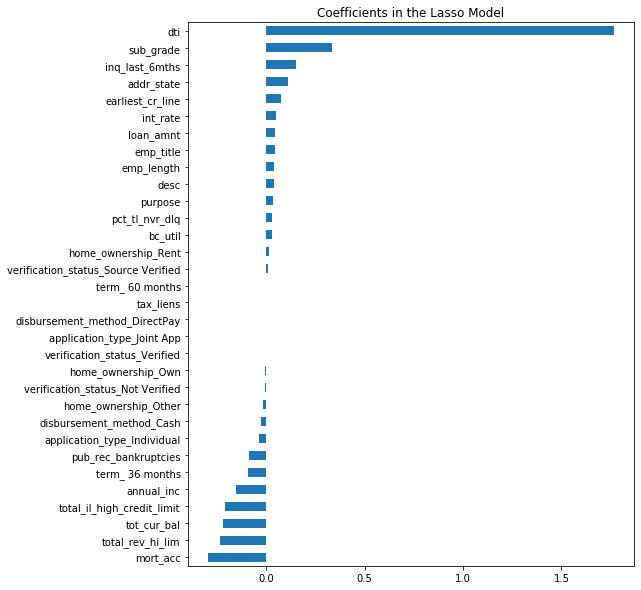

In [36]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef.sort_values().plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [37]:
sel_lasso = SelectFromModel(estimator=Lasso(alpha=lassocv.alpha_, random_state=0))
sel_lasso.fit(X, Y)

SelectFromModel(estimator=Lasso(alpha=2.98510624597147e-05, copy_X=True,
                                fit_intercept=True, max_iter=1000,
                                normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [38]:
X.columns[sel_lasso.get_support()]

Index(['term_ 36 months', 'home_ownership_Other', 'home_ownership_Own',
       'home_ownership_Rent', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'application_type_Individual',
       'disbursement_method_Cash', 'loan_amnt', 'int_rate', 'sub_grade',
       'emp_title', 'emp_length', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'earliest_cr_line', 'inq_last_6mths', 'tot_cur_bal', 'total_rev_hi_lim',
       'bc_util', 'mort_acc', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies',
       'total_il_high_credit_limit', 'desc'],
      dtype='object')

### 4.5.2 Random Forest

In [39]:
random_forest = RandomForestClassifier(n_estimators = 100, n_jobs=5, random_state=0)
sel = SelectFromModel(random_forest, threshold=0.02)
sel.fit(X, Y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=5,
                                                 oob_score=False,
  

Text(0.5, 1.0, 'Feature importance Random forest')

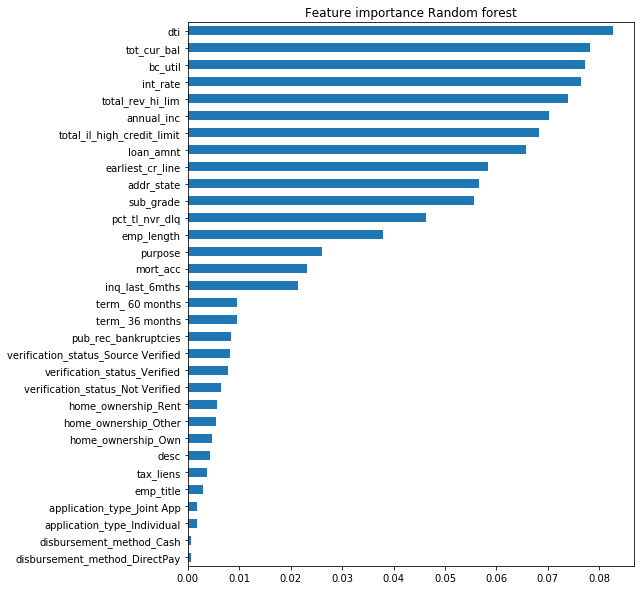

In [40]:
coef2 = pd.Series(sel.estimator_.feature_importances_, index = X.columns)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef2.sort_values().plot(kind = "barh")
plt.title("Feature importance Random forest")

In [41]:
X.columns[sel.get_support()]

Index(['loan_amnt', 'int_rate', 'sub_grade', 'emp_length', 'annual_inc',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths',
       'tot_cur_bal', 'total_rev_hi_lim', 'bc_util', 'mort_acc',
       'pct_tl_nvr_dlq', 'total_il_high_credit_limit'],
      dtype='object')

In [42]:
X_forest = X[['loan_amnt', 'int_rate', 'sub_grade', 'emp_length', 'annual_inc',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths',
       'tot_cur_bal', 'total_rev_hi_lim', 'bc_util', 'mort_acc',
       'pct_tl_nvr_dlq', 'total_il_high_credit_limit']]

In [43]:
X_forest.head()

,loan_amnt,int_rate,sub_grade,emp_length,annual_inc,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,tot_cur_bal,total_rev_hi_lim,bc_util,mort_acc,pct_tl_nvr_dlq,total_il_high_credit_limit
0,0.746835,0.663551,0.558824,0.104062,0.010753,0.559260,0.479404,0.03146,0.962963,0.0,0.226832,0.039461,0.138104,0.027027,0.895,0.119063
1,1.000000,0.421729,0.382353,0.226491,0.004839,0.336189,0.531787,0.05153,0.925926,0.0,0.130178,0.050683,0.198174,0.027027,1.000,0.196094
2,0.493671,0.087617,0.058824,0.000000,0.010753,0.336189,0.210001,0.01992,0.802469,0.0,0.247698,0.079577,0.088045,0.135135,0.947,0.087365
3,0.101266,0.233645,0.205882,0.000000,0.004140,0.336189,0.516637,0.00564,0.851852,0.0,0.013993,0.027305,0.085100,0.000000,0.917,0.028714
4,0.493671,0.492991,0.441176,0.138724,0.006129,0.559260,0.210001,0.02318,0.753086,0.0,0.016019,0.067982,0.148410,0.027027,1.000,0.000000


## 4.6 Split in train and test

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X_forest, Y, test_size=0.3, random_state=0)

In [45]:
print(X_train.shape); print(X_test.shape)

(895098, 16)
(383614, 16)


In [46]:
ytrain_df = pd.DataFrame(Y_train, columns = ['target'])
ytest_df = pd.DataFrame(Y_test, columns = ['target'])

In [47]:
ytrain_df['target'].value_counts(normalize=True)

0    0.794073
1    0.205927
Name: target, dtype: float64

In [48]:
ytest_df['target'].value_counts(normalize=True)

0    0.795114
1    0.204886
Name: target, dtype: float64

In [49]:
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
np.savetxt("../data/Y_train.csv", Y_train, delimiter=",")
np.savetxt("../data/Y_test.csv", Y_test, delimiter=",")

In [50]:
print(X_train.shape); print(X_test.shape);
print(Y_train.shape); print(Y_test.shape)

(895098, 16)
(383614, 16)
(895098,)
(383614,)
